In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from IPython.display import display, clear_output
import time
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [3]:
def show_image(tensor):
    # Ensure the input is a 2D tensor of shape 28x28
    if tensor.shape != (28, 28):
        raise ValueError("Input tensor must be of shape 28x28")
    
    # Convert tensor to numpy array if it's a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().numpy()

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.title("28x28 Image")
    plt.axis('off')
    plt.show()

# Data

In [4]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert the datasets to single tensors
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

# Move data to GPU
train_data, train_labels = train_data.to(device), train_labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)

### Warmup :Extracting 100 samples per class for the initialization

In [245]:
# Initialize containers for the extracted samples
num_classes = 10
samples_per_class = 100
extracted_data = []
extracted_labels = []

# Container to mark indices to be removed
mask = torch.ones(train_labels.size(0), dtype=torch.bool, device=device)

# Extract 100 samples for each class
for class_idx in range(num_classes):
    class_indices = (train_labels == class_idx).nonzero(as_tuple=True)[0]
    selected_indices = class_indices[:samples_per_class]

    extracted_data.append(train_data[selected_indices])
    extracted_labels.append(train_labels[selected_indices])

    # Mark these indices as False in the mask
    mask[selected_indices] = False

# Concatenate the extracted samples into tensors
extracted_data = torch.cat(extracted_data, dim=0)
extracted_labels = torch.cat(extracted_labels, dim=0)

# Create new dataset tensors without the extracted samples
remaining_data = train_data[mask]
remaining_labels = train_labels[mask]

print(f'Extracted data shape: {extracted_data.shape}')
print(f'Remaining data shape: {remaining_data.shape}')

Extracted data shape: torch.Size([1000, 1, 28, 28])
Remaining data shape: torch.Size([59000, 1, 28, 28])


In [246]:
# Compute the averaged images and the treshold distance: 
extracted_data
extracted_labels

# Initialize accumulators
num_classes = 10
image_shape = extracted_data.shape[2:]  # Shape of MNIST images
class_sums = torch.zeros((num_classes, *image_shape), dtype=torch.float32, device=device)
class_counts = torch.zeros(num_classes, dtype=torch.float32, device=device)

# Compute the sums and counts per class
for i in range(num_classes):
    class_mask = (extracted_labels == i).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    class_images = extracted_data * class_mask.float()
    class_sums[i] = class_images.sum(dim=0)
    class_counts[i] = class_mask.float().sum()

# Compute the mean per pixel per class
class_means = class_sums / class_counts.view(-1, 1, 1)

print(class_means.shape)  # Should be (10, 28, 28)

torch.Size([10, 28, 28])


In [255]:
# Reshape class_means to match the test_data dimensions for broadcasting
class_means = class_means.view(num_classes, 1, *image_shape)  # Reshape: (10, 1, 28, 28)

# Compute the L2 distance between each test image and each class mean
# Using broadcasting to compute (10, N, 28, 28) - (N, 28, 28) => (10, N, 28, 28)
dists = torch.sum((extracted_data.unsqueeze(1) - class_means) ** 2, dim=(2, 3))  # Shape: (10, N)
dists = torch.sqrt(dists)


torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [272]:
p = torch.randn([100, 1, 784]) - torch.randn([1, 784])
p.shape

torch.Size([100, 1, 784])

In [274]:
#Initialize an empty list to store the results
result_chunks = []
a = extracted_data.reshape(*extracted_data.shape[:2], -1)
b = class_means.reshape(*class_means.shape[:2], -1)

# Loop over each element in b and the corresponding chunk in a
for i in range(10):
    chunk_a = a[i*100:(i+1)*100]  # Select the chunk of 100 elements from a
    chunk_b = b[i]  # Select the element from b and add two dimensions
    #print(chunk_a.shape, chunk_b.shape)
    
    distances = torch.sum(torch.square(chunk_a - chunk_b) , dim=2) # this is the distances for all n w same label
    distances = torch.sqrt(distances)
    #print("100 ?",distances.shape) # should be (100 distances and then u want to average them)
    result_chunks.append(distances)  # Multiply and append the result

# Concatenate all the chunks back together
result = torch.cat(result_chunks, dim=0)

print(result.shape)  

torch.Size([1000, 1])


In [279]:
reshaped_a = result.view(10, 100)

# Sum and average the values along the second dimension (axis 1)
sum_values = reshaped_a.sum(dim=1)
average_values = reshaped_a.mean(dim=1)

print(f'Average values: {average_values}')

Average values: tensor([6.9448, 4.7728, 7.1184, 6.6091, 6.2137, 6.6941, 6.0981, 5.9110, 6.2883,
        5.8607], device='cuda:7')


In [280]:
warmup_thresholds=  average_values

In [282]:
warmup_representations = class_means.reshape(class_means.shape[0], -1)
warmup_representations.shape

torch.Size([10, 784])

### Network

In [299]:
class CustomNetwork(nn.Module):
    def __init__(self, input_shape, num_classes, max_neurons, warmup_size, warmup_representation):
        super(CustomNetwork, self).__init__()
        
        #self.distance_threshold = torch.tensor([7.0076, 4.8702, 7.0092, 6.5455, 6.4295, 6.6409, 6.5635, 5.8766, 6.5613,5.9182], device= device)*1.20

        ## WARMUP
        self.distance_threshold = torch.tensor([6.9448, 4.7728, 7.1184, 6.6091, 6.2137, 6.6941, 6.0981, 5.9110, 6.2883,
        5.8607], device= device)

        
        
        #torch.zeros(10) # contains the thresholds per neuron.
        self.input_shape = input_shape
        self.max_neurons = max_neurons
        self.warmup_size = warmup_size
        
        # Initialize neurons tensor
        # Each row: [label, flattened memory tensor, update counter]
        self.neurons = torch.zeros((max_neurons, 1 + input_shape[0] * input_shape[1] + 1))
        self.neurons[:, 0] = -1 # uninitalized labels
        self.neurons[:num_classes, 0] = torch.arange(num_classes, dtype=torch.float32) # initialize the labels supposing its [0,numclass-1]
        self.neurons[:, -1] = 0  # Initialize counters to 0
        # Put the tensor in device
        self.neurons = self.neurons.to(device)

        self.current_neurons = num_classes # initial occupied neurons , 10.

        # WARMUP
        self.neurons[:num_classes, 1:-1] = warmup_representation # INITIALIZE 10 NEURONS

    def forward(self, x):
        pass

    def train_network(self, train_data, labels):

        for i, (input_tensor, label) in enumerate(zip(train_data,labels)):
            #if i>1000:
            #    break
            input_tensor = input_tensor.view(-1)  # Flatten the input tensor
            label = label.item()  # Assuming label is a single element tensor

            ############
            label_mask = self.neurons[:, 0] == label
            #print("LABEL", label)
            label_indices = torch.nonzero(label_mask)
            #print(input_tensor.shape,  self.neurons.shape, self.neurons[label_mask][:, 1:-1].shape)
            #torch.Size([784]) torch.Size([1000, 786]) torch.Size([1, 784])
            #print(label_mask)
            #this is only for the first inputs to prevent 0 division for the first 10 initialized neurons / warmup
            w = self.neurons[label_mask][:, -1]
            if(self.current_neurons == 10):
                w = torch.where(w != 0, w, torch.ones_like(w))
                #print(w)
                
            d = self.neurons[label_mask][:, 1:-1] * 1/w.unsqueeze(1)
            
            distances = torch.sum(torch.square(input_tensor - d) , dim=1) # this is the distances for all n w same label
            distances = torch.sqrt(distances)
            #print('distances',distances)


            #distances = torch.norm(input_tensor - self.neurons[label_mask][:, 1:-1] , dim=1) # this is the distances for all n w same label
            min_index = torch.min(distances, dim=0)[1].item() #gives the index of the minimum.
            #print("WTF")
            #print(torch.min(distances, dim=0)[1].item())
            #closest_distance_mask = distances == torch.min(distances)
            #break

            # if the closest_distance_mask isn't empty or if the max number of neurons has been reached
            if (distances[min_index] < self.distance_threshold[label]) or (self.current_neurons >= self.max_neurons) or i<self.warmup_size :
                # debugging
                #if (distances[closest_distance_mask] < self.distance_threshold[label]):
                    #print('add into existing neuron',distances[closest_distance_mask] )
        
                #if (not(self.current_neurons < self.max_neurons) and i%1000):
                    #print('add into the closest neuron because memory full ', distances[closest_distance_mask], distances)

                #else:
                    #print('Warmup', distances[closest_distance_mask])

                    
                closest_distance_index = label_indices[min_index]
                
                #print("adding to index ", closest_distance_index)
                self.neurons[closest_distance_index, -1] += 1 # update counter

                
                #weight = 1/self.neurons[closest_distance_index, -1] #get counter for update
                #print('WEIGHT', weight)
                #print('UPDATE', input_tensor.unsqueeze(0) * weight)
                #update = self.neurons[closest_distance_index, 1:-1] + input_tensor
                self.neurons[closest_distance_index, 1:-1] += input_tensor # here you would do the average operation
                
            # if self.current_neurons < self.max_neurons //// memory isn't full
            else:
                #find empty neurons and get in the first one: 
                #print(distances)
                masko = self.neurons[:, 0] == -1

                label_indices = torch.arange(self.neurons.shape[0], dtype=torch.float32)

                first_index = int(label_indices[masko][0].item())

                #print('add into a new neuron: ', first_index)


                self.neurons[first_index, 0] = label
                self.neurons[first_index, 1:-1] = input_tensor
                self.neurons[first_index, -1] = 1
                # if none found this is a omega bug
                
                # Add the new neuron to the neurons tensor
                self.current_neurons += 1
            
    def predict(self, input_tensors):
        
        input_tensors = input_tensors.reshape(*input_tensors.shape[:2],-1)  # Flatten the input tensors #(20k, 784) - (20, 784)

        w = self.neurons[:, -1]
       
        d = self.neurons[:, 1:-1] * 1/w.unsqueeze(1)
        # remove uninitialized neurons
        mask = self.neurons[:,0] != -1
        print('mask', mask.shape)

        last_column = self.neurons[:, 0]
        count_equal_to_minus_one = (last_column == -1).sum().item()
        print("elements", count_equal_to_minus_one)
        
        distances = torch.sum(torch.square(input_tensors - d[mask]) , dim=2) # this is the distances for all n w same label
        distances = torch.sqrt(distances) #shape inputs, neurons

        predictions = torch.min(distances, dim=1)[1]# indexes of the neurons
        predicted_labels = self.neurons[predictions, 0]
        #print(predicted_labels.shape)
        
        return predicted_labels

    def get_neuron_tensors(self): 
        return self.neurons

# 100 neurons

In [140]:
# Testing Adding Neurons
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
max_neurons = 100
warmup_size = 100 # number of inputs used to initialize our neurons

networkTestAdd = CustomNetwork(input_shape, num_classes, max_neurons, warmup_size)

In [141]:
networkTestAdd.train_network(train_data,train_labels)

In [142]:
brain = networkTestAdd.get_neuron_tensors()
brain.shape

torch.Size([100, 786])

In [145]:
brain[:,-1]

tensor([2.3500e+03, 2.0770e+03, 1.5510e+03, 1.4090e+03, 2.2030e+03, 1.1610e+03,
        1.3550e+03, 1.4820e+03, 1.8380e+03, 1.6490e+03, 7.3100e+02, 5.1000e+02,
        4.5400e+02, 4.3600e+02, 1.7390e+03, 5.3700e+02, 5.8000e+02, 7.2400e+02,
        3.5800e+02, 8.0700e+02, 7.4900e+02, 9.1200e+02, 6.5100e+02, 1.0080e+03,
        1.0490e+03, 6.8000e+01, 8.8700e+02, 7.7400e+02, 3.7600e+02, 1.1030e+03,
        2.2320e+03, 1.0000e+02, 1.2840e+03, 1.4030e+03, 1.9400e+02, 8.5900e+02,
        6.6000e+01, 2.2600e+02, 4.2000e+01, 8.3000e+01, 1.0950e+03, 6.8000e+02,
        3.5800e+02, 5.8100e+02, 4.8100e+02, 1.6500e+02, 2.6200e+02, 2.7400e+02,
        5.0200e+02, 1.9900e+02, 6.6000e+01, 2.2700e+02, 7.0500e+02, 1.3840e+03,
        2.1000e+01, 8.8800e+02, 5.5100e+02, 4.0000e+00, 2.1200e+02, 2.7400e+02,
        1.1500e+02, 1.3710e+03, 1.1000e+02, 4.3400e+02, 6.5000e+01, 1.0100e+02,
        5.2900e+02, 3.6000e+02, 2.9000e+01, 6.0000e+00, 8.9500e+02, 7.4800e+02,
        8.3600e+02, 1.6700e+02, 2.4300e+

In [146]:
predictions = networkTestAdd.predict(test_data)

W SHAPE torch.Size([100])
brain torch.Size([100, 784])
torch.Size([10000])


In [147]:
correct_predictions = (predictions == test_labels)

accuracy = correct_predictions.sum().item() / len(test_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.00%


In [61]:
brain[:,-1]

tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.],
       device='cuda:7')

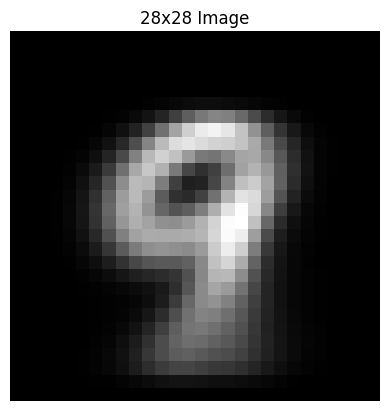

In [62]:
show_image(brain[9,1:-1].reshape(28,28))

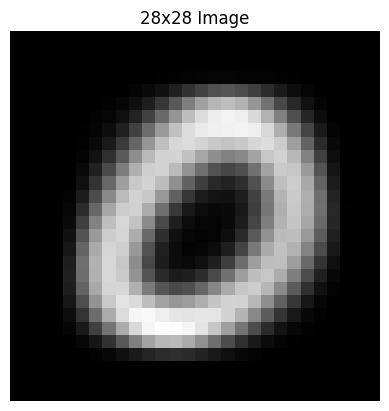

In [63]:
show_image(brain[0,1:-1].reshape(28,28))

### 500 neurons

In [158]:
# Testing Adding Neurons
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
max_neurons = 500
warmup_size = 100 # number of inputs used to initialize our neurons

networkTestAdd1 = CustomNetwork(input_shape, num_classes, max_neurons, warmup_size)

In [159]:
networkTestAdd1.train_network(train_data,train_labels)

In [160]:
brain1 = networkTestAdd1.get_neuron_tensors()
brain1.shape

torch.Size([500, 786])

In [161]:
predictions1 = networkTestAdd1.predict(test_data)

W SHAPE torch.Size([500])
brain torch.Size([500, 784])
torch.Size([10000])


In [163]:
correct_predictions = (predictions1 == test_labels)

accuracy = correct_predictions.sum().item() / len(test_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 92.06%


### 1000 neurons

In [294]:
# Testing Adding Neurons
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
max_neurons = 1000
warmup_size = 100 # number of inputs used to initialize our neurons

ThousandNeuronNet = CustomNetwork(input_shape, num_classes, max_neurons, warmup_size, warmup_representations)
ThousandNeuronNet = ThousandNeuronNet.to(device)

#Train
ThousandNeuronNet.train_network(train_data,train_labels)

In [295]:
t = ThousandNeuronNet.get_neuron_tensors()

In [296]:
# Out of 1000 intial nuerons 462 were never used.

In [297]:
last_column = t[:, 0]
count_equal_to_minus_one = (last_column == -1).sum().item()
count_equal_to_minus_one

345

In [241]:
test_data.shape

torch.Size([10000, 1, 28, 28])

In [298]:
#Predict
# Split the test data into two halves
half_size = test_data.size(0) // 2
test_data_first_half = test_data[:half_size]
test_data_second_half = test_data[half_size:]

predictions_first_half = ThousandNeuronNet.predict(test_data_first_half)

predictions_second_half = ThousandNeuronNet.predict(test_data_second_half)
predictions = torch.cat((predictions_first_half, predictions_second_half), dim=0)
print('PREDICTIONS',predictions.shape)


correct_predictions = (predictions == test_labels)

accuracy = correct_predictions.sum().item() / len(test_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')

mask torch.Size([1000])
elements 345
mask torch.Size([1000])
elements 345
PREDICTIONS torch.Size([10000])
Accuracy: 92.63%


### WARMUP

100 neurons

In [300]:
# Testing Adding Neurons
input_shape = (28, 28)  # Example input shape (e.g., 28x28 images)
num_classes = 10
max_neurons = 100
warmup_size = 100 # number of inputs used to initialize our neurons

networkTestAdd = CustomNetwork(input_shape, num_classes, max_neurons, warmup_size, warmup_representations)

In [301]:
networkTestAdd.train_network(train_data,train_labels)

In [302]:
predictions = networkTestAdd.predict(test_data)

mask torch.Size([100])
elements 0


In [303]:
correct_predictions = (predictions == test_labels)

accuracy = correct_predictions.sum().item() / len(test_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.60%


In [304]:
p = networkTestAdd.get_neuron_tensors()
p.shape

torch.Size([100, 786])

In [305]:
p[:, -1]

tensor([ 878., 1644.,  847., 1551., 1536.,  884.,  976., 1005., 1318., 1548.,
         506.,  351., 1207.,  750.,  326.,  155.,  748.,   48., 1329.,  764.,
         876.,   96.,  309.,  189.,  470.,  987.,  914., 1638.,  279.,  154.,
         545.,  564.,  323.,  482.,  539.,  358.,  217.,  377.,  249.,  908.,
         254., 1117.,  437., 1223.,  637.,  169.,  751.,  312.,  597.,  642.,
         615.,  396.,   70.,  744.,  124.,  766.,  602.,  697.,  600.,  279.,
         692.,  523.,  848.,  575.,  472.,  619.,  425.,  223.,  456.,   73.,
         466.,  603.,  552.,  577.,  502., 1309.,  580.,  666.,  657.,  156.,
         186.,  474.,  178.,  836.,  787.,  880.,  386.,  111.,  358.,  977.,
         180.,  578.,  116.,  104.,  196.,  467.,  499.,  802.,  800.,  234.],
       device='cuda:7')

In [306]:
p[:,0]

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 5., 7., 1., 3., 0., 2., 9., 3.,
        1., 0., 9., 2., 2., 0., 2., 6., 4., 1., 5., 1., 5., 7., 7., 2., 8., 8.,
        7., 4., 9., 0., 7., 8., 2., 9., 4., 7., 9., 2., 3., 2., 3., 6., 2., 8.,
        2., 4., 7., 1., 0., 3., 0., 7., 2., 7., 0., 6., 5., 2., 6., 1., 8., 3.,
        0., 5., 6., 8., 6., 3., 5., 0., 3., 2., 2., 3., 6., 7., 0., 2., 9., 5.,
        2., 4., 6., 5., 9., 5., 6., 7., 4., 4.], device='cuda:7')

In [318]:
p[17, -1]

tensor(48., device='cuda:7')

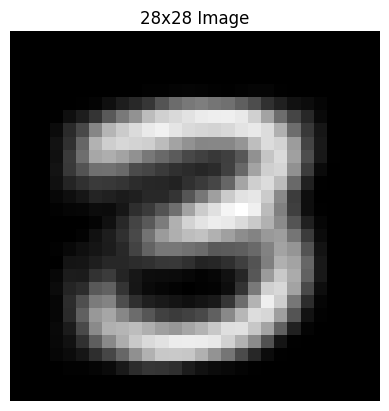

In [317]:
show_image(p[17, 1:-1].reshape(28,28))

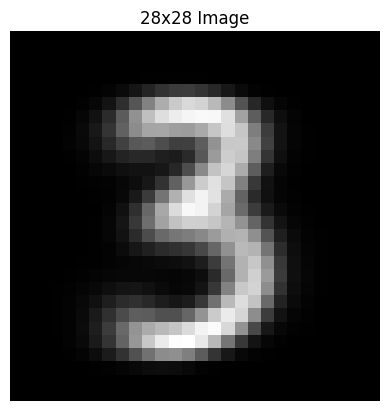

In [320]:
show_image(p[3, 1:-1].reshape(28,28))